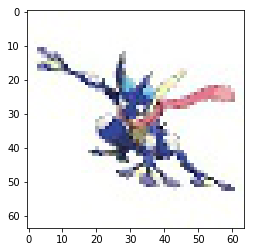

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 22 18:48:52 2018

Author: Gorkem Polat
e-mail: polatgorkem@gmail.com

Written with Spyder IDE
"""

import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
%matplotlib inline

startTime = time.time()

tf.reset_default_graph()

folderPath = "pokemons_64"
IMG_WIDTH, IMG_HEIGHT, CHANNEL = 64, 64, 3

num_iteration = 50000
learning_step_D = 0.001
learning_step_G = 0.001
batch_size = 16

n_discriminatorOutput = 1
n_noise = 100
 
filelist = glob.glob(folderPath+"/*")
X_data = np.zeros((len(filelist), IMG_WIDTH, IMG_HEIGHT, CHANNEL))

# Read all images into a numpy array
for i in range(len(filelist)):
    X_data[i,:,:,:] = mpimg.imread(filelist[i])/255

random_pokemon = X_data[np.random.randint(0, X_data.shape[0]),:,:,:]
plt.imshow(random_pokemon)
plt.show()

In [14]:
# Define placeholders, since we are using batch normalization, we have to define
# an extra parameter that indicates training and testing
X = tf.placeholder(tf.float32, [None, IMG_HEIGHT, IMG_WIDTH, CHANNEL])
z = tf.placeholder(tf.float32, [None, n_noise])
is_training = tf.placeholder(dtype=tf.bool)

# Construct the graphs
# Discriminator
def discriminator(input_image, is_training=is_training, reuse=None):
    c1, c1_f, c2, c2_f, c3, c3_f, n_hidden = 5, 32, 5, 32, 5, 32, 128
    with tf.variable_scope("discriminator", reuse=reuse):
            
        x = tf.layers.conv2d(input_image, kernel_size=[c1, c1], filters=c1_f, strides=[2, 2], padding="SAME")        
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.elu(x)
        
        x = tf.layers.conv2d(input_image, kernel_size=[c2, c2], filters=c2_f, strides=[2, 2], padding="SAME")        
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.elu(x)

        x = tf.layers.conv2d(input_image, kernel_size=[c3, c3], filters=c3_f, strides=[2, 2], padding="SAME")        
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.elu(x)        

        x = tf.layers.dense(x, units=n_hidden, activation=tf.nn.elu)
        x = tf.layers.dense(x, units=n_discriminatorOutput, activation=tf.nn.sigmoid)
        
        return x
       
# Generator
def generator(input_noise, is_training=is_training):
    n_hidden, n_hidden_dim, c1, c1_f, c2, c2_f, c3, c3_f, c4, c4_f = 4, 32, 5, 32, 5, 32, 3, 16, 3, 3   
    with tf.variable_scope("generator", reuse=None):
        
        x = tf.layers.dense(input_noise, units=n_hidden*n_hidden*n_hidden_dim, activation=tf.nn.elu)
        x = tf.reshape(x, shape=[-1, n_hidden, n_hidden, n_hidden_dim])
        
        x = tf.layers.conv2d_transpose(x, c1_f, kernel_size=[c1, c1], strides=[2, 2], padding="SAME")
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.elu(x)        
        
        x = tf.layers.conv2d_transpose(x, c2_f, kernel_size=[c2, c2], strides=[2, 2], padding="SAME")
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.elu(x)        

        x = tf.layers.conv2d_transpose(x, c3_f, kernel_size=[c3, c3], strides=[2, 2], padding="SAME")
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.elu(x)   
        
        x = tf.layers.conv2d_transpose(x, c3_f, kernel_size=[c3, c3], strides=[1, 1], padding="SAME")
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.elu(x)

        x = tf.layers.conv2d_transpose(x, c4_f, kernel_size=[c4, c4], strides=[2, 2], padding="SAME")
        x = tf.nn.sigmoid(x)        

        return x   #64*64*3

In [15]:
generated_samples = generator(z, is_training)
D_real = discriminator(X, is_training)
D_fake = discriminator(generated_samples, is_training, reuse=True)

discriminator_variables = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
generator_variables     = [var for var in tf.trainable_variables() if var.name.startswith("generator")]

loss_discriminator_D = -tf.math.log(D_real)
loss_discriminator_G = -tf.math.log(1-D_fake)
loss_discriminator = tf.reduce_mean(loss_discriminator_D+loss_discriminator_G)

loss_generator = tf.reduce_mean(-tf.math.log(D_fake))

# Optimizers

optimizer_D = tf.train.AdamOptimizer(learning_rate=learning_step_D).minimize(loss_discriminator, var_list=discriminator_variables)
optimizer_G = tf.train.AdamOptimizer(learning_rate=learning_step_G).minimize(loss_generator, var_list=generator_variables)

session = tf.Session()
session.run(tf.global_variables_initializer())

log_step = 20
static_noise_size = 5

loss_log_discriminator = np.array(np.zeros(int(num_iteration/log_step)))
loss_log_generator = np.array(np.zeros(int(num_iteration/log_step)))

satic_noise = np.random.normal(size=(static_noise_size, n_noise))               

def train(num_iterations):
    counter = 0
    k_D = 1
    k_G = 1
    for i in range(num_iterations):
        
        # Train Discriminator
        for i_D in range(k_D):   
            randomIDs = np.random.permutation(X_data.shape[0])
            x_batch = X_data[randomIDs[0:batch_size], :, :, :]
            noise_batch = np.random.normal(size=(batch_size, n_noise))

            feed_dict_D = {X: x_batch, z:noise_batch, is_training:True}
            session.run(optimizer_D, feed_dict=feed_dict_D)
        
        # Train Generator
        for i_G in range(k_G):
            noise_batch = np.random.normal(size=(batch_size, n_noise))
            feed_dict_G = {z: noise_batch, is_training:True}
            session.run(optimizer_G, feed_dict=feed_dict_G)
        
        
        if (i%log_step == 0):                
            loss_log_discriminator[counter] = session.run(loss_discriminator, feed_dict=feed_dict_D)                   
            
            feed_dict_G = {z: satic_noise, is_training:False}
            loss_log_generator[counter] = session.run(loss_generator, feed_dict=feed_dict_G)                        
            
            if i%200==0:
                print("iteration: "+str(i) + " | discriminator loss: "+str(loss_log_discriminator[counter])+ " | generator loss: "+str(loss_log_generator[counter]))
                
                if i%4000==0:                    
                    generated_images = session.run(generated_samples, feed_dict=feed_dict_G)
                    #reshaped_generated_images = np.reshape(generated_images, newshape=(static_noise_size,IMG_HEIGHT, IMG_WIDTH, CHANNEL))
                    reshaped_generated_images = generated_images
                    
                    f, axes = plt.subplots(1, static_noise_size, figsize=(20, 4))
                    for img_index in range(static_noise_size):
                        axes[img_index].grid(False)
                        axes[img_index].imshow(reshaped_generated_images[img_index])
                    plt.show()
                    
                    endTime = time.time()            
                    print("Time elapsed: " +str((endTime-startTime)//60)+ " minutes")
                    
            counter = counter + 1

iteration: 0 | discriminator loss: 1.40888905525 | generator loss: 0.646575450897


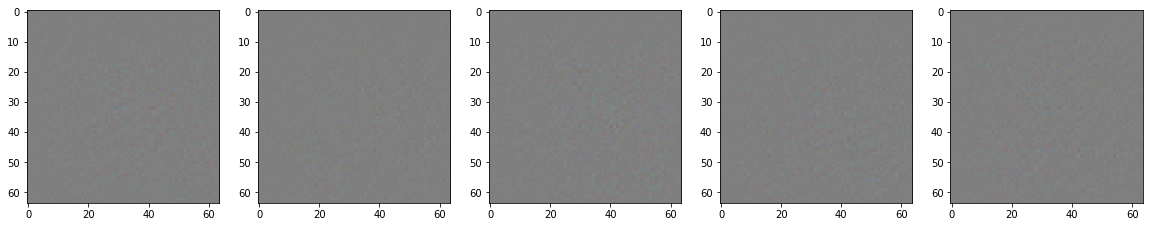

Time elapsed: 0.0 minutes
iteration: 200 | discriminator loss: 1.25652456284 | generator loss: 2.14765548706
iteration: 400 | discriminator loss: 1.60693776608 | generator loss: 0.910980522633
iteration: 600 | discriminator loss: 1.15765810013 | generator loss: 1.58251357079
iteration: 800 | discriminator loss: 0.868715405464 | generator loss: 3.12041783333
iteration: 1000 | discriminator loss: 1.37810599804 | generator loss: 2.38122868538
iteration: 1200 | discriminator loss: 1.19478797913 | generator loss: 3.20973658562
iteration: 1400 | discriminator loss: 1.27839720249 | generator loss: 0.906677126884
iteration: 1600 | discriminator loss: 1.24396884441 | generator loss: 1.62327229977
iteration: 1800 | discriminator loss: 1.40645670891 | generator loss: 1.12294173241
iteration: 2000 | discriminator loss: 1.41738247871 | generator loss: 0.901218414307
iteration: 2200 | discriminator loss: 1.28134822845 | generator loss: 0.832757949829
iteration: 2400 | discriminator loss: 1.347718119

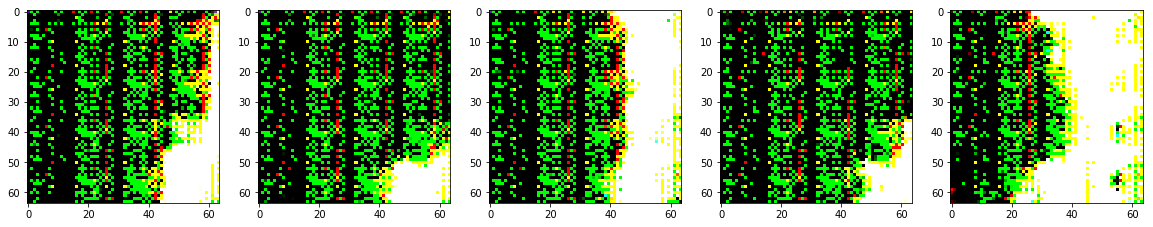

Time elapsed: 0.0 minutes
iteration: 4200 | discriminator loss: 1.09764933586 | generator loss: 2.35112142563
iteration: 4400 | discriminator loss: 1.14540266991 | generator loss: 3.48684835434
iteration: 4600 | discriminator loss: 1.06193315983 | generator loss: 3.97701573372
iteration: 4800 | discriminator loss: 1.29094099998 | generator loss: 1.41324567795
iteration: 5000 | discriminator loss: 1.32855606079 | generator loss: 3.42230343819
iteration: 5200 | discriminator loss: 1.22827386856 | generator loss: 3.78109931946
iteration: 5400 | discriminator loss: 1.10644841194 | generator loss: 5.19289159775
iteration: 5600 | discriminator loss: 1.32686138153 | generator loss: 5.96756458282
iteration: 5800 | discriminator loss: 1.08058857918 | generator loss: 8.19145202637
iteration: 6000 | discriminator loss: 1.09630918503 | generator loss: 3.31938695908
iteration: 6200 | discriminator loss: 1.13076627254 | generator loss: 5.36747837067
iteration: 6400 | discriminator loss: 1.0730289220

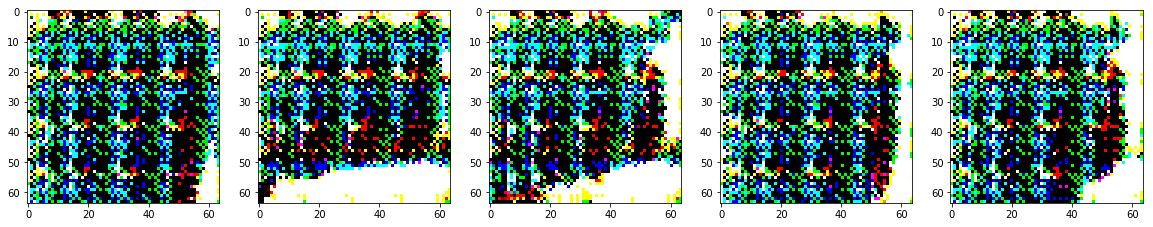

Time elapsed: 1.0 minutes
iteration: 8200 | discriminator loss: 1.24506485462 | generator loss: 5.9168419838
iteration: 8400 | discriminator loss: 1.36449217796 | generator loss: 9.21800041199
iteration: 8600 | discriminator loss: 1.378480196 | generator loss: 9.26286697388
iteration: 8800 | discriminator loss: 1.33871209621 | generator loss: 7.20412921906
iteration: 9000 | discriminator loss: 1.20334196091 | generator loss: 4.54038000107
iteration: 9200 | discriminator loss: 1.31779885292 | generator loss: 9.54117393494
iteration: 9400 | discriminator loss: 1.08389699459 | generator loss: 1.02167189121
iteration: 9600 | discriminator loss: 1.37224292755 | generator loss: 1.39243602753
iteration: 9800 | discriminator loss: 1.36175239086 | generator loss: 2.91797995567
iteration: 10000 | discriminator loss: 1.34116196632 | generator loss: 5.66889476776
iteration: 10200 | discriminator loss: 1.30575096607 | generator loss: 3.50467300415
iteration: 10400 | discriminator loss: 1.2575664520

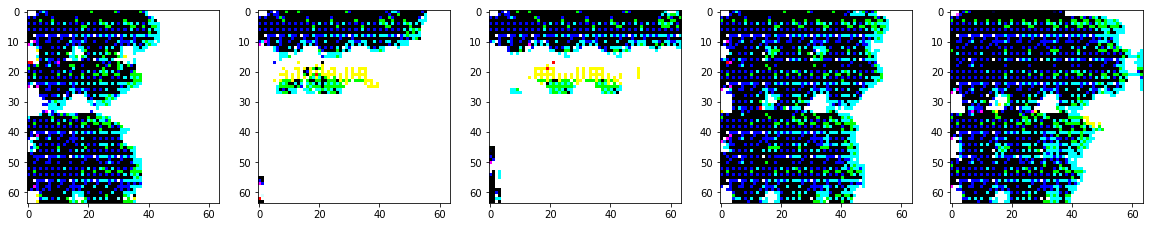

Time elapsed: 2.0 minutes
iteration: 12200 | discriminator loss: 1.37665605545 | generator loss: 38.3845329285
iteration: 12400 | discriminator loss: 1.25700545311 | generator loss: 26.6679573059
iteration: 12600 | discriminator loss: 1.32292592525 | generator loss: 22.3230247498
iteration: 12800 | discriminator loss: 1.29669189453 | generator loss: 19.5085124969
iteration: 13000 | discriminator loss: 1.32594740391 | generator loss: 22.4109573364
iteration: 13200 | discriminator loss: 1.31016421318 | generator loss: 23.845407486
iteration: 13400 | discriminator loss: 1.3375647068 | generator loss: 31.5049285889
iteration: 13600 | discriminator loss: 1.44272577763 | generator loss: 10.4714622498
iteration: 13800 | discriminator loss: 1.3270676136 | generator loss: 16.606842041
iteration: 14000 | discriminator loss: 1.3318464756 | generator loss: 17.5215148926
iteration: 14200 | discriminator loss: 1.29282271862 | generator loss: 19.2722568512
iteration: 14400 | discriminator loss: 1.217

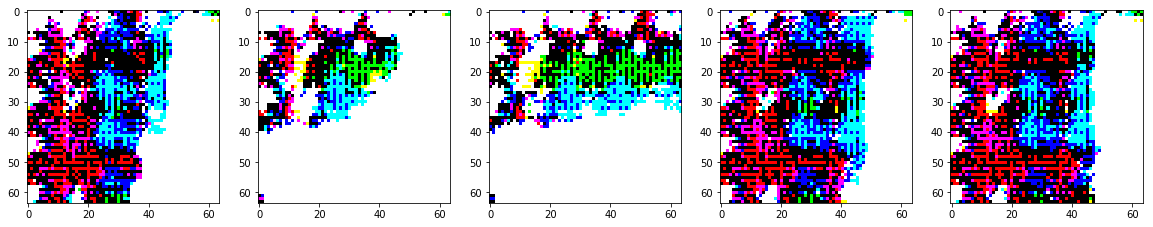

Time elapsed: 2.0 minutes
iteration: 16200 | discriminator loss: 1.29792451859 | generator loss: 14.4365797043
iteration: 16400 | discriminator loss: 1.34600424767 | generator loss: 15.1737613678
iteration: 16600 | discriminator loss: 1.34878385067 | generator loss: 28.9221801758
iteration: 16800 | discriminator loss: 1.37659823895 | generator loss: 11.5077457428
iteration: 17000 | discriminator loss: 1.27892768383 | generator loss: 36.1130218506
iteration: 17200 | discriminator loss: 1.25388717651 | generator loss: 16.6155281067
iteration: 17400 | discriminator loss: 1.40001296997 | generator loss: 27.8421897888
iteration: 17600 | discriminator loss: 1.28485012054 | generator loss: 28.3013858795
iteration: 17800 | discriminator loss: 1.32232654095 | generator loss: 23.3991012573
iteration: 18000 | discriminator loss: 1.3768171072 | generator loss: 14.3495922089
iteration: 18200 | discriminator loss: 1.32436990738 | generator loss: 27.5038700104
iteration: 18400 | discriminator loss: 1

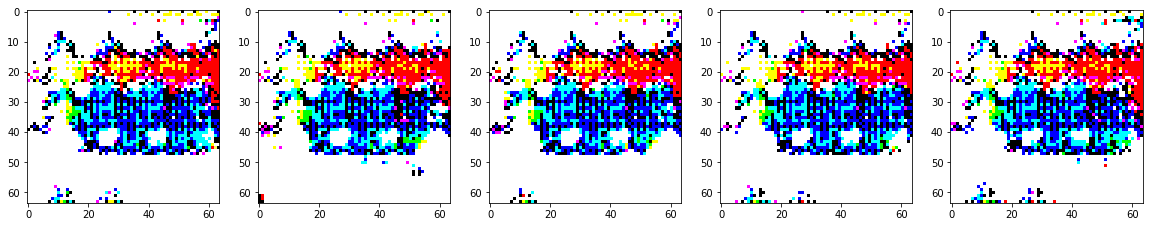

Time elapsed: 3.0 minutes
iteration: 20200 | discriminator loss: 1.34776639938 | generator loss: 10.4255619049
iteration: 20400 | discriminator loss: 1.35993409157 | generator loss: 11.3232498169
iteration: 20600 | discriminator loss: 1.33453249931 | generator loss: 28.4758815765
iteration: 20800 | discriminator loss: 1.40943360329 | generator loss: 20.7743415833
iteration: 21000 | discriminator loss: 1.36108469963 | generator loss: 17.1922683716
iteration: 21200 | discriminator loss: 1.35343575478 | generator loss: 24.2603416443
iteration: 21400 | discriminator loss: 1.34731209278 | generator loss: 18.2076148987
iteration: 21600 | discriminator loss: 1.36075592041 | generator loss: 22.9737586975
iteration: 21800 | discriminator loss: 1.36647593975 | generator loss: 37.9726333618
iteration: 22000 | discriminator loss: 1.36620426178 | generator loss: 36.4066467285
iteration: 22200 | discriminator loss: 1.36790251732 | generator loss: 34.1771240234
iteration: 22400 | discriminator loss: 

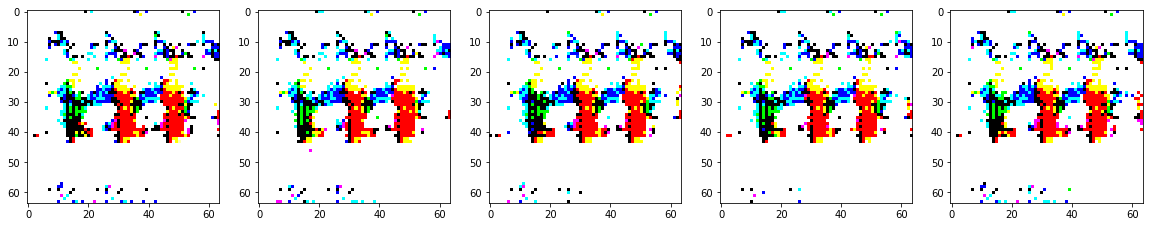

Time elapsed: 4.0 minutes
iteration: 24200 | discriminator loss: 1.35127997398 | generator loss: 30.8034629822
iteration: 24400 | discriminator loss: 1.42231464386 | generator loss: 27.1413841248
iteration: 24600 | discriminator loss: 1.34296262264 | generator loss: 33.5561752319
iteration: 24800 | discriminator loss: 1.30387306213 | generator loss: 15.254778862
iteration: 25000 | discriminator loss: 1.29927825928 | generator loss: 38.0932388306
iteration: 25200 | discriminator loss: 1.37936544418 | generator loss: 44.6401481628
iteration: 25400 | discriminator loss: 1.31364345551 | generator loss: 25.6713600159
iteration: 25600 | discriminator loss: 1.34798538685 | generator loss: 14.8929595947
iteration: 25800 | discriminator loss: 1.36930847168 | generator loss: 16.8687324524
iteration: 26000 | discriminator loss: 1.38606452942 | generator loss: 21.9886569977
iteration: 26200 | discriminator loss: 1.35276460648 | generator loss: 21.5693531036
iteration: 26400 | discriminator loss: 1

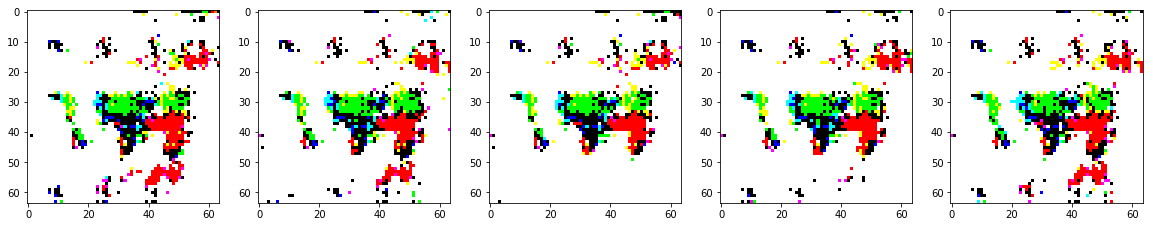

Time elapsed: 4.0 minutes
iteration: 28200 | discriminator loss: 1.36338996887 | generator loss: 12.5010042191
iteration: 28400 | discriminator loss: 1.35215914249 | generator loss: 3.5547618866
iteration: 28600 | discriminator loss: 1.39395987988 | generator loss: 10.4215660095
iteration: 28800 | discriminator loss: 1.35835599899 | generator loss: 9.01066875458
iteration: 29000 | discriminator loss: 1.39736926556 | generator loss: 10.6770763397
iteration: 29200 | discriminator loss: 1.3825366497 | generator loss: 8.63575839996
iteration: 29400 | discriminator loss: 1.34229183197 | generator loss: 8.24206352234
iteration: 29600 | discriminator loss: 1.36667740345 | generator loss: 8.26655578613
iteration: 29800 | discriminator loss: 1.35928153992 | generator loss: 21.0318565369
iteration: 30000 | discriminator loss: 1.39976871014 | generator loss: 35.4650039673
iteration: 30200 | discriminator loss: 1.3467040062 | generator loss: 35.9007949829
iteration: 30400 | discriminator loss: 1.3

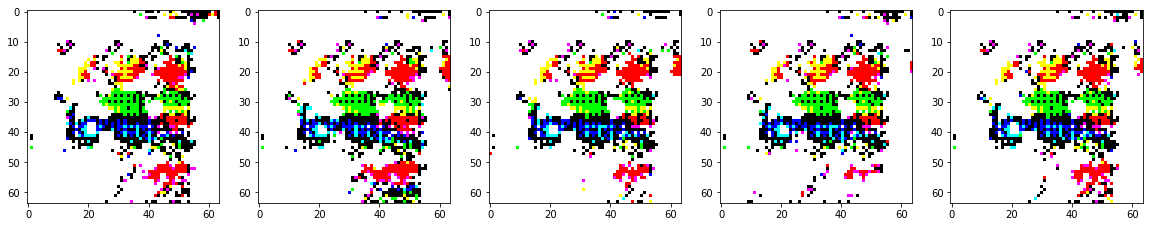

Time elapsed: 5.0 minutes
iteration: 32200 | discriminator loss: 1.34650015831 | generator loss: 17.1791572571
iteration: 32400 | discriminator loss: 1.30519115925 | generator loss: 20.9216957092
iteration: 32600 | discriminator loss: 1.33810949326 | generator loss: 53.9588508606
iteration: 32800 | discriminator loss: 1.38301205635 | generator loss: 37.0289306641
iteration: 33000 | discriminator loss: 1.40915632248 | generator loss: 35.4952926636
iteration: 33200 | discriminator loss: 1.35406923294 | generator loss: 34.9109802246
iteration: 33400 | discriminator loss: 1.38269543648 | generator loss: 27.9215049744
iteration: 33600 | discriminator loss: 1.42228150368 | generator loss: 24.2614898682
iteration: 33800 | discriminator loss: 1.3805564642 | generator loss: 25.1460323334
iteration: 34000 | discriminator loss: 1.38657689095 | generator loss: 20.9578094482
iteration: 34200 | discriminator loss: 1.36145496368 | generator loss: 16.4585609436
iteration: 34400 | discriminator loss: 1

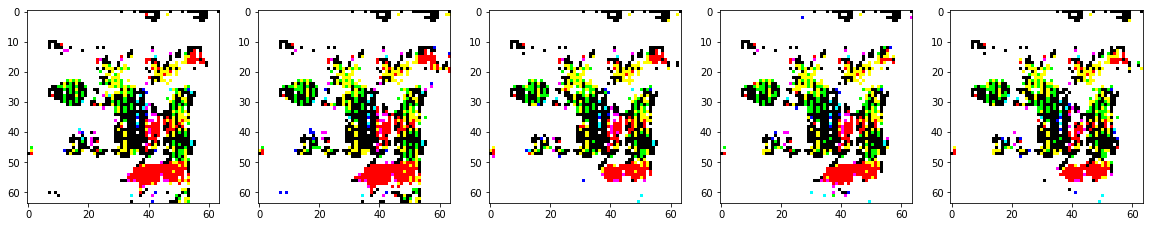

Time elapsed: 6.0 minutes
iteration: 36200 | discriminator loss: 1.33674120903 | generator loss: 43.0733718872
iteration: 36400 | discriminator loss: 1.32895231247 | generator loss: 34.9668083191
iteration: 36600 | discriminator loss: 1.34142994881 | generator loss: 34.402885437
iteration: 36800 | discriminator loss: 1.38741612434 | generator loss: 18.7486667633
iteration: 37000 | discriminator loss: 1.3935482502 | generator loss: 41.5229873657
iteration: 37200 | discriminator loss: 1.40533792973 | generator loss: 38.0632019043
iteration: 37400 | discriminator loss: 1.34703600407 | generator loss: 32.5738945007
iteration: 37600 | discriminator loss: 1.41387701035 | generator loss: 19.2006149292
iteration: 37800 | discriminator loss: 1.43500936031 | generator loss: 17.406162262
iteration: 38000 | discriminator loss: 1.33923649788 | generator loss: 11.6598758698
iteration: 38200 | discriminator loss: 1.36555361748 | generator loss: 24.6344184875
iteration: 38400 | discriminator loss: 1.3

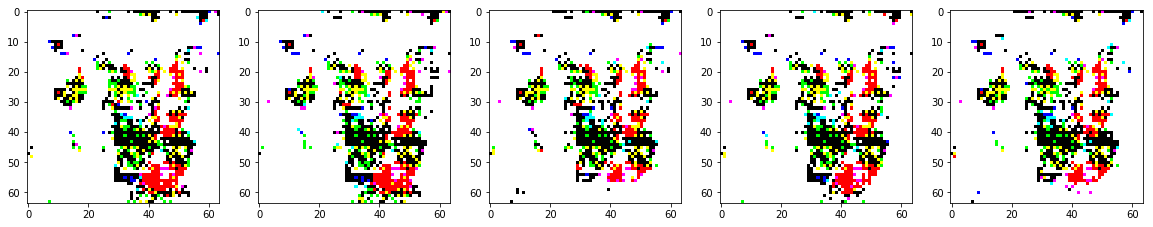

Time elapsed: 6.0 minutes
iteration: 40200 | discriminator loss: 1.37356030941 | generator loss: 13.2890167236
iteration: 40400 | discriminator loss: 1.41193401814 | generator loss: 6.14377450943
iteration: 40600 | discriminator loss: 1.35972046852 | generator loss: 11.0015916824
iteration: 40800 | discriminator loss: 1.39653348923 | generator loss: 20.2319431305
iteration: 41000 | discriminator loss: 1.39171409607 | generator loss: 10.39564991
iteration: 41200 | discriminator loss: 1.39966452122 | generator loss: 15.5247449875
iteration: 41400 | discriminator loss: 1.37998175621 | generator loss: 4.75923442841
iteration: 41600 | discriminator loss: 1.35389375687 | generator loss: 0.839170455933
iteration: 41800 | discriminator loss: 1.35830903053 | generator loss: 16.4216957092
iteration: 42000 | discriminator loss: 1.36492216587 | generator loss: 42.4187736511
iteration: 42200 | discriminator loss: 1.42303967476 | generator loss: 28.9471530914
iteration: 42400 | discriminator loss: 1

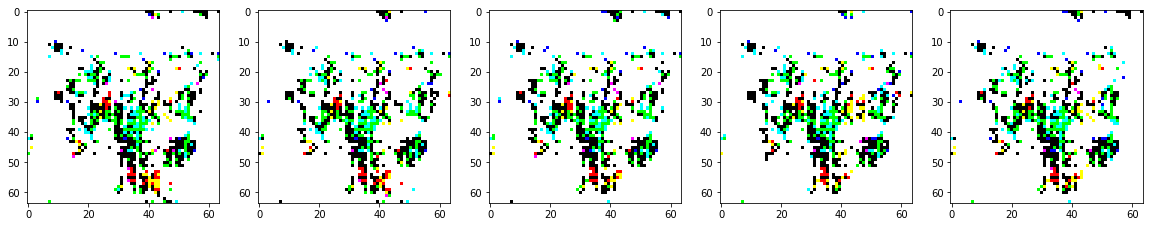

Time elapsed: 7.0 minutes
iteration: 44200 | discriminator loss: 1.37581515312 | generator loss: 21.988079071
iteration: 44400 | discriminator loss: 1.40277981758 | generator loss: 22.8222808838
iteration: 44600 | discriminator loss: 1.35416340828 | generator loss: 18.8509750366
iteration: 44800 | discriminator loss: 1.38281965256 | generator loss: 15.809545517
iteration: 45000 | discriminator loss: 1.35285103321 | generator loss: 16.0194034576
iteration: 45200 | discriminator loss: 1.40243196487 | generator loss: 30.7588500977
iteration: 45400 | discriminator loss: 1.41280436516 | generator loss: 9.26493930817
iteration: 45600 | discriminator loss: 1.36763525009 | generator loss: 18.1953468323
iteration: 45800 | discriminator loss: 1.37719345093 | generator loss: 13.2198390961
iteration: 46000 | discriminator loss: 1.38321113586 | generator loss: 12.7035703659
iteration: 46200 | discriminator loss: 1.38293266296 | generator loss: 10.6450824738
iteration: 46400 | discriminator loss: 1.

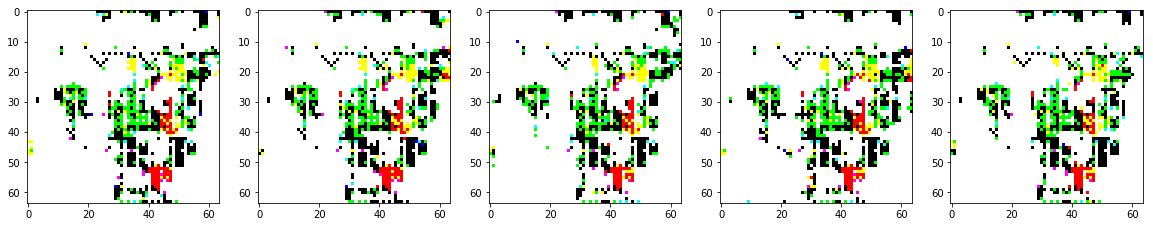

Time elapsed: 8.0 minutes
iteration: 48200 | discriminator loss: 1.37936365604 | generator loss: 9.12698936462
iteration: 48400 | discriminator loss: 1.3844063282 | generator loss: 6.37411785126
iteration: 48600 | discriminator loss: 1.38763701916 | generator loss: 6.6894826889
iteration: 48800 | discriminator loss: 1.47327435017 | generator loss: 9.63081741333
iteration: 49000 | discriminator loss: 1.33887326717 | generator loss: 2.58556604385
iteration: 49200 | discriminator loss: 1.3929207325 | generator loss: 0.55804336071
iteration: 49400 | discriminator loss: 1.37570047379 | generator loss: 0.364726185799
iteration: 49600 | discriminator loss: 1.39992272854 | generator loss: 0.407073497772
iteration: 49800 | discriminator loss: 1.39532625675 | generator loss: 0.560895562172
Training duration: 8.0 minutes


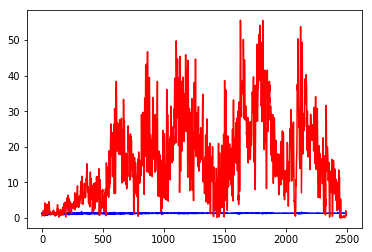

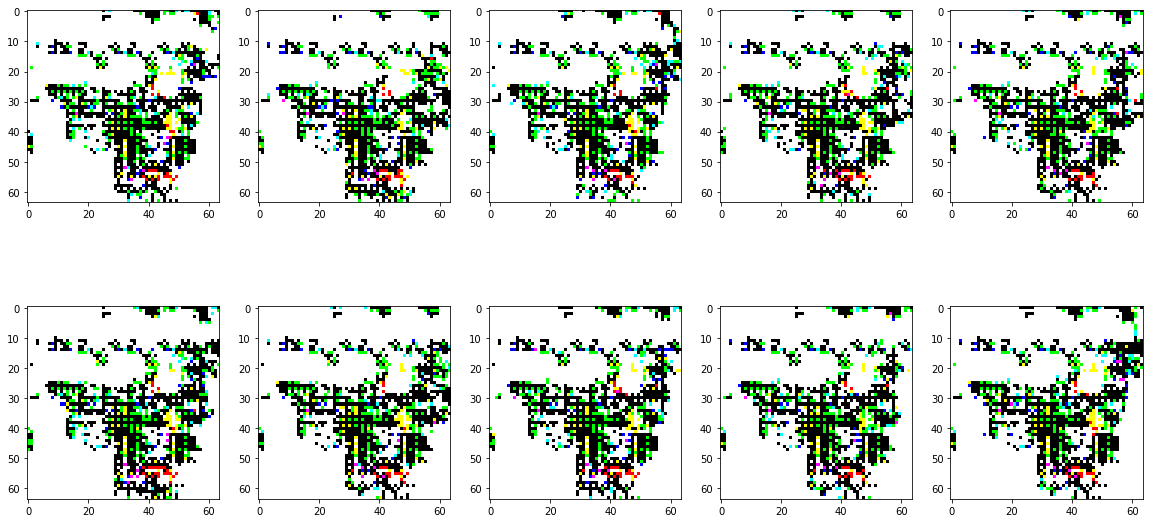

In [16]:

train(num_iterations=num_iteration)
endTime = time.time()            

print("Training duration: " +str((endTime-startTime)//60)+ " minutes")
plt.plot(loss_log_discriminator, 'b')
plt.plot(loss_log_generator, 'r')
plt.show()

test_noise_size = 10
test_noise = np.random.normal(size=(test_noise_size, n_noise))
feed_dict_G = {z: test_noise, is_training:False}
generated_images = session.run(generated_samples, feed_dict=feed_dict_G)
reshaped_generated_images = generated_images

f, axes = plt.subplots(2, 5, figsize=(20,10))
for img_index in range(test_noise_size):
    if (img_index < int(test_noise_size/2)):
        axes[0, img_index].grid(False)
        axes[0, img_index].imshow(reshaped_generated_images[img_index])
    else:
        axes[1, img_index-int(test_noise_size/2)].grid(False)
        axes[1, img_index-int(test_noise_size/2)].imshow(reshaped_generated_images[img_index])
plt.show()

session.close()